In [2]:
from traffic import rho_red_light, computeF

In [3]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)
    Computes "red light" initial condition with shock
    
    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density



In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [7]:
# Basic inital condition parameters
# defining grid size, time steps, CFL condition, etc....
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = np.linspace(0,4,nx-1)

rho = rho_red_light(nx-1, rho_max, rho_in)

In [8]:
def animate(data):
    x = np.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [9]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Compute the solution with the Godunov scheme using the 
    Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho     : array of floats
            Density at current time-step
    nt      : int
            Number of time steps
    dt      : float
            Time-step size
    dx      : float
            Mesh spacing
    rho_max : float
            Maximum allowed car density
    V_max   : float
            Speed limit
            
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = np.zeros((nt,len(rho)))
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    #setup some temporary arrays
    rho_plus = np.zeros_like(rho)
    rho_minus = np.zeros_like(rho)
    flux = np.zeros_like(rho)
    
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:]  # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy()   # array at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) +\
                      computeF(V_max, rho_max, rho_plus) +\
                      dx/dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n    

In [10]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)   #make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)


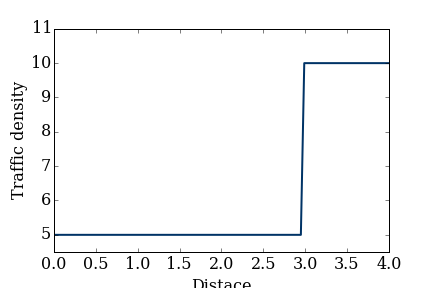
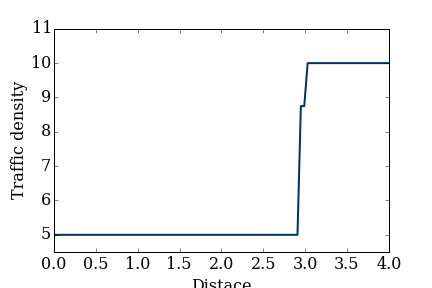
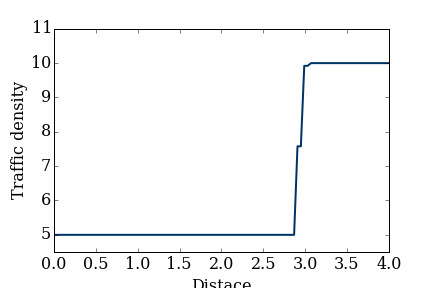
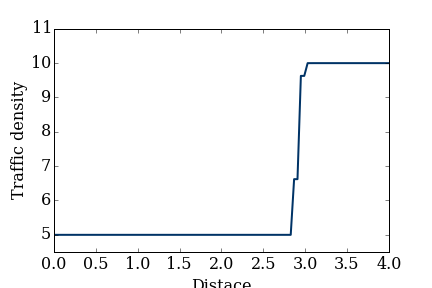
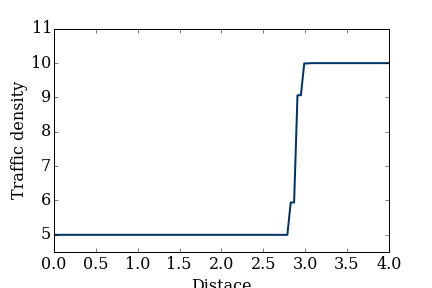
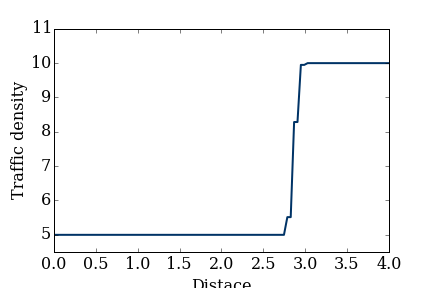
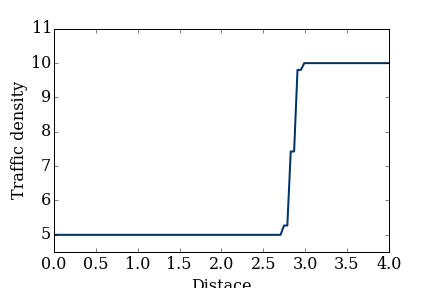
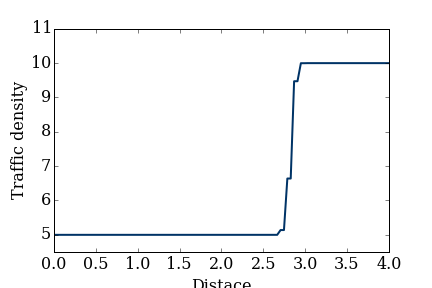
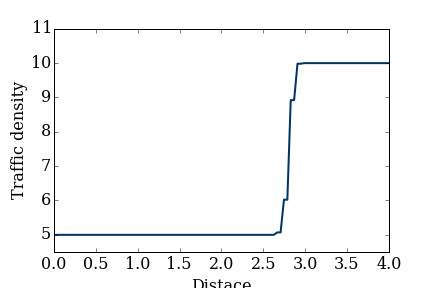
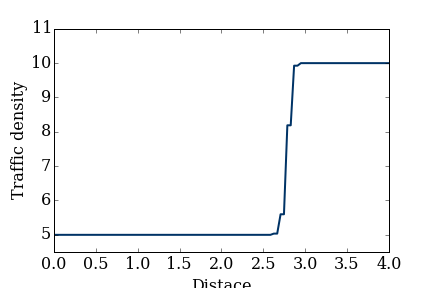
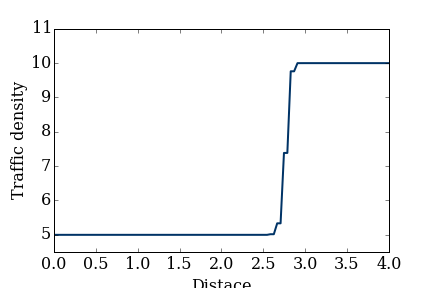
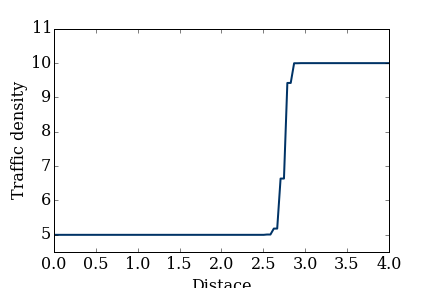
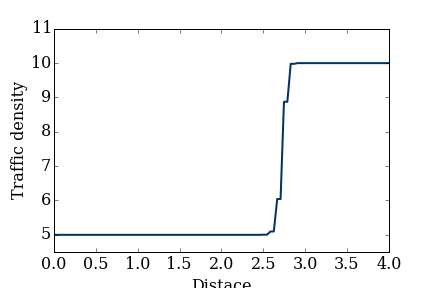
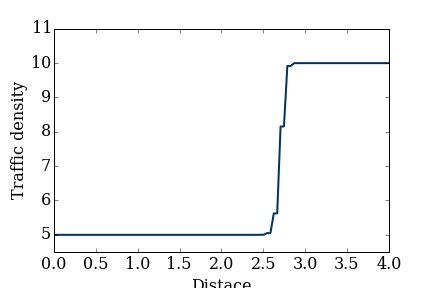
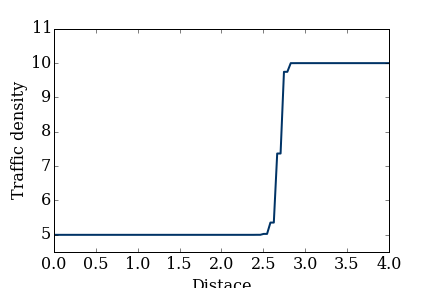
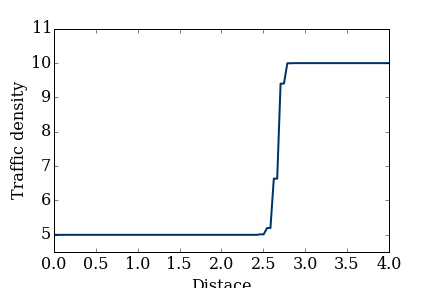
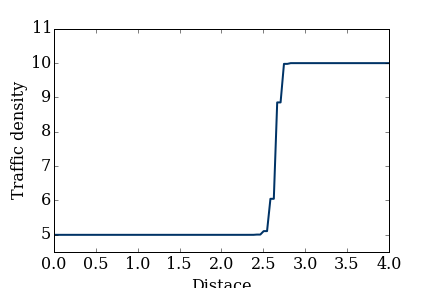
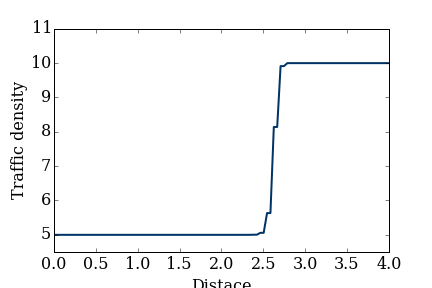
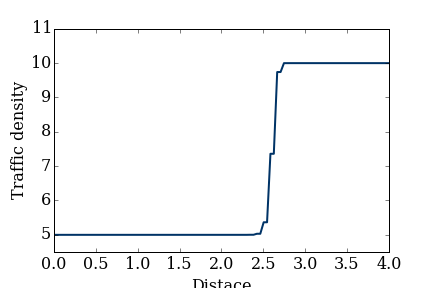
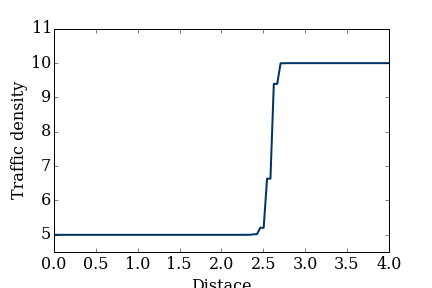
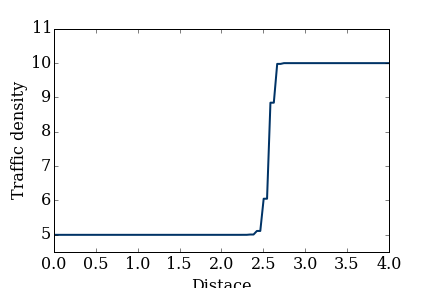
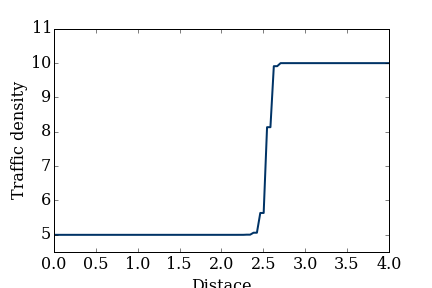
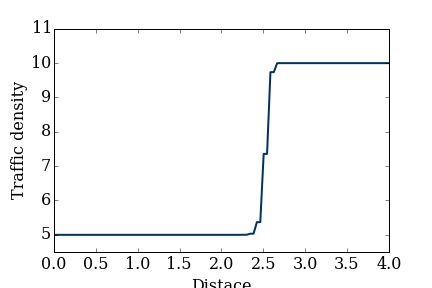
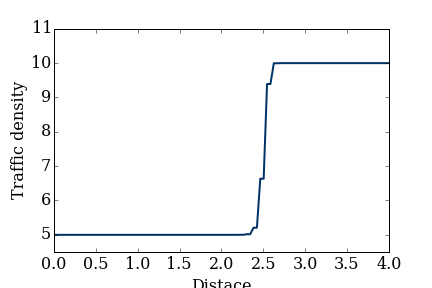
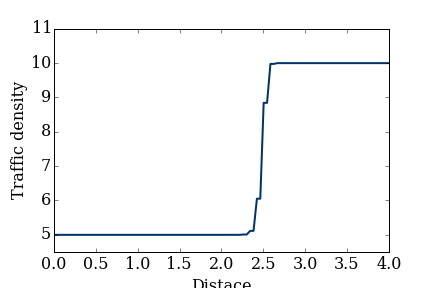
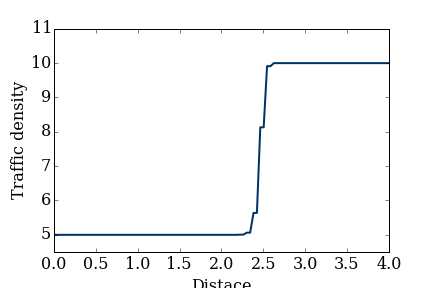
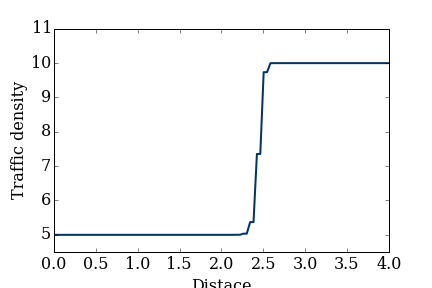
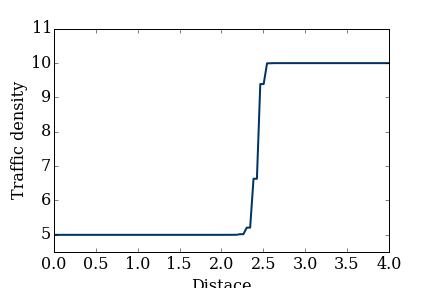
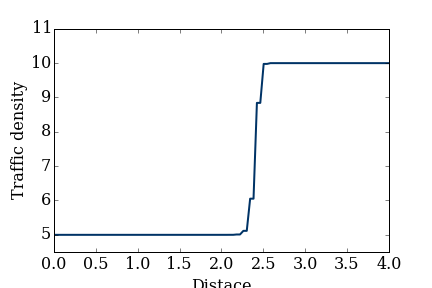
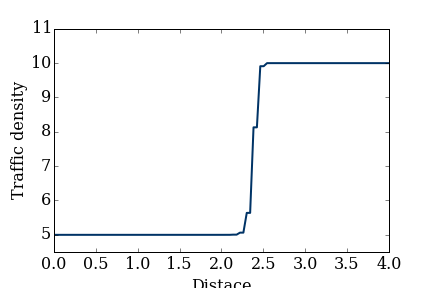

In [12]:
fig = plt.figure();
ax = plt.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distace'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

## MUSCL schemes

In [13]:
def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e  : array of float
        input data
    dx : float
        spacestep
        
    Returns
    -------
    sigma : array of float
            minmod slope
    """
    
    sigma = np.zeros_like(e)
    de_minus = np.ones_like(e)
    de_plus = np.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (np.abs(de_minus[i]) < np.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

## Evolution in time

In [17]:
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using the 
    Lax-Friedrichs flux, RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
            
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    # initialize our results array with dimensions nt by nx
    rho_n = np.zeros((nt,len(rho)))
    #copy the inital u array into each row of our new array
    rho_n[:,:] = rho.copy()
    #setup some temporary arrays
    rho_plus = np.zeros_like(rho)
    rho_minus = np.zeros_like(rho)
    flux = np.zeros_like(rho)
    rho_star = np.zeros_like(rho)
    
    """for t in range(1,nt):
        
        sigma = minmod(rho,dx)  # calculate minmod slope
        
        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2
        rho_right = rho - sigma*dx/2
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - \
                          dt/dx * (rho_right[1:] - rho-left[:-1]))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx)  # calculate minmod slope
        
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - \
                          dx/dt * (rho_right[1:] - rho_left[:-1]))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx *\
                        (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n"""
    for t in range(1,nt):
               
        sigma = minmod(rho,dx) #calculate minmod slope

        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.     
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx) #calculate minmod slope
    
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [18]:
sigma = 1
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)


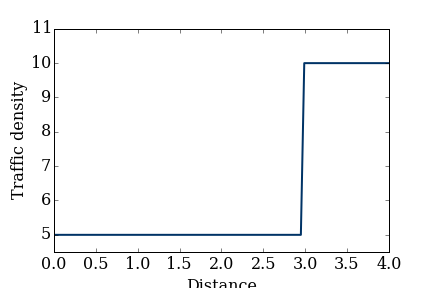
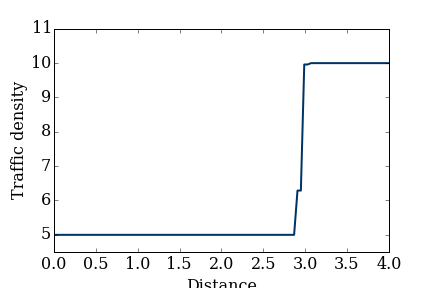
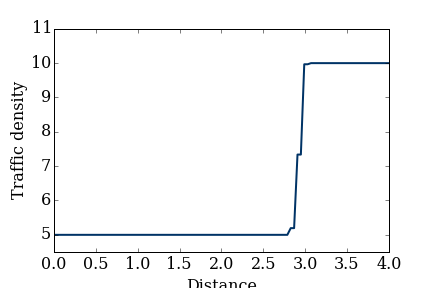
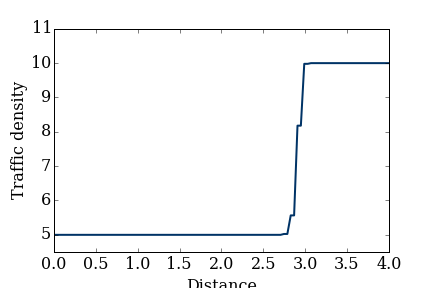
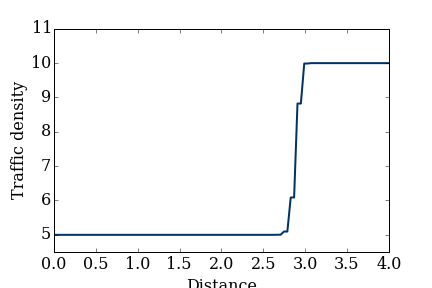
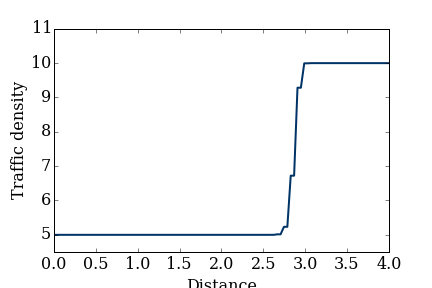
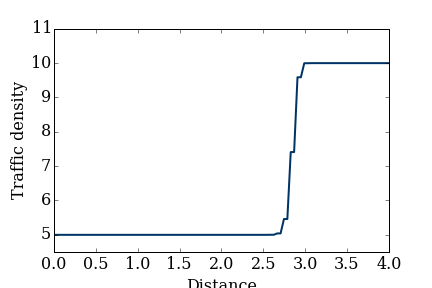
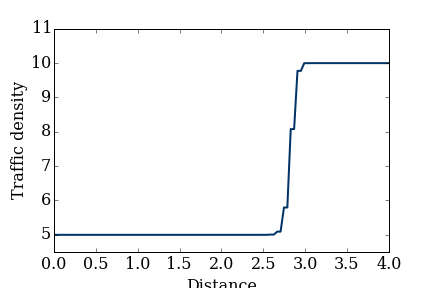
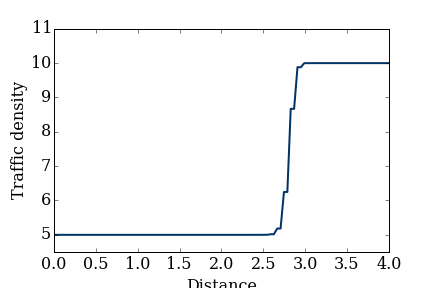
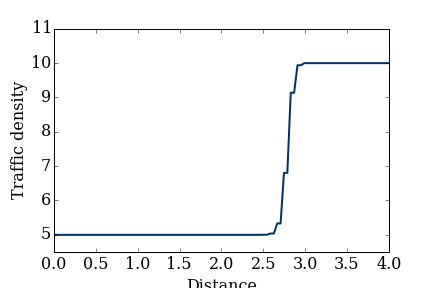
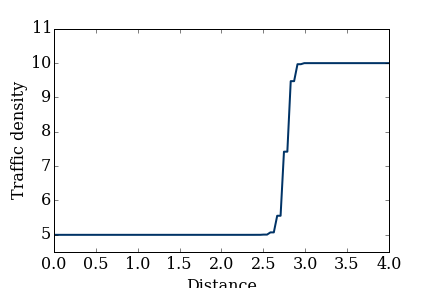
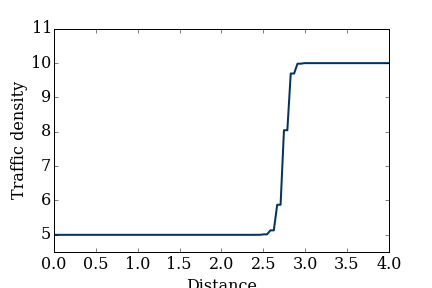
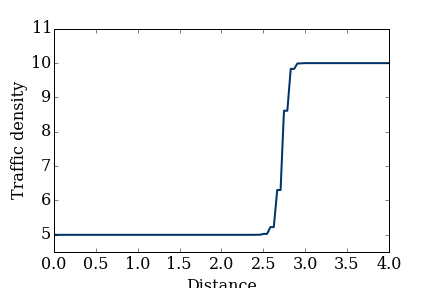
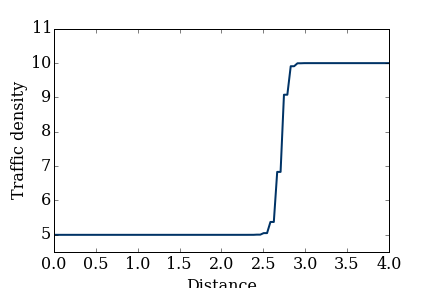
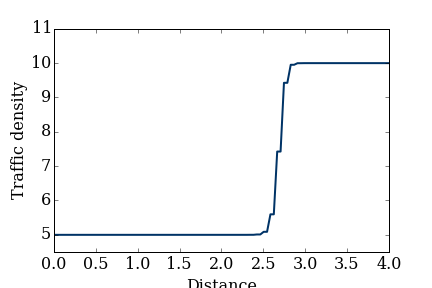
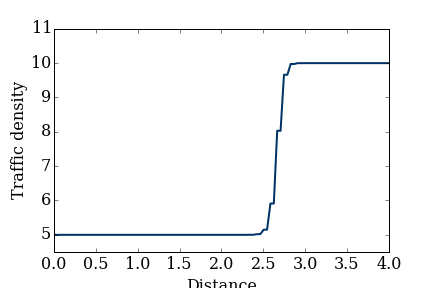
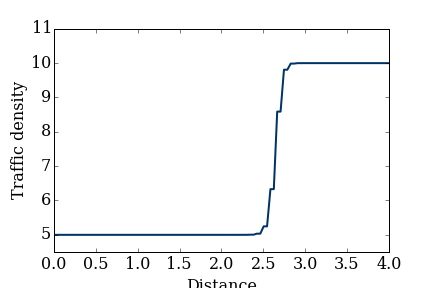
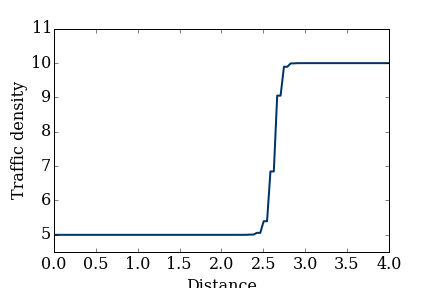
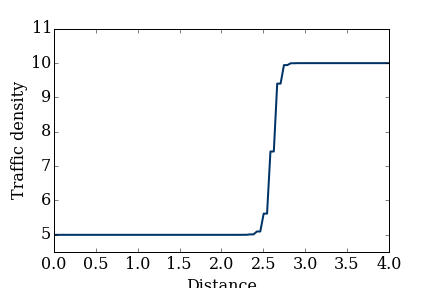
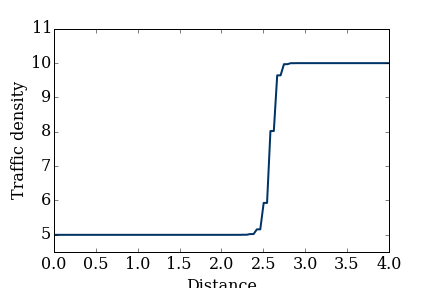
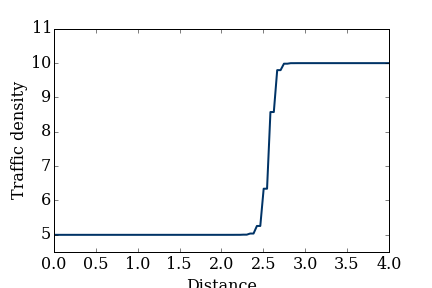
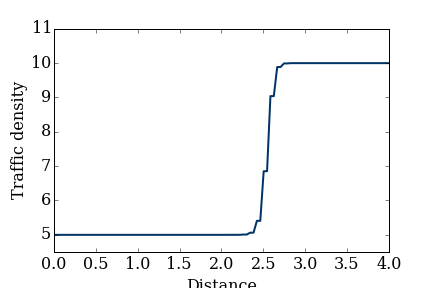
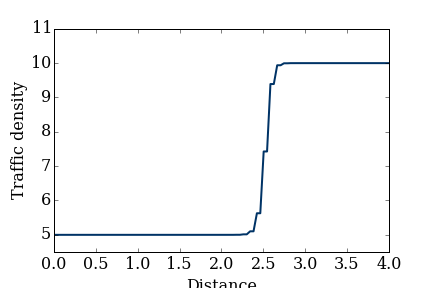
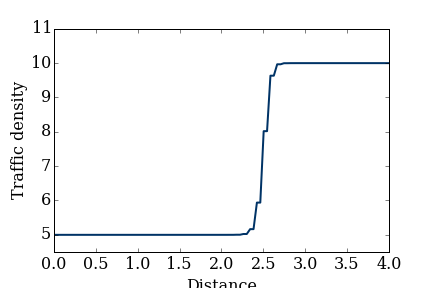
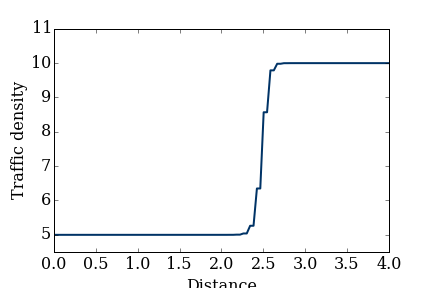
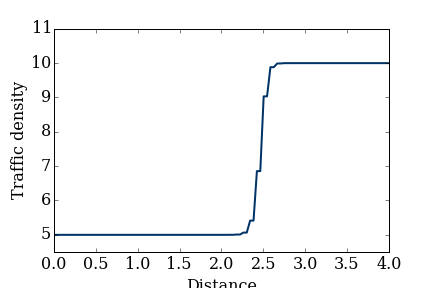
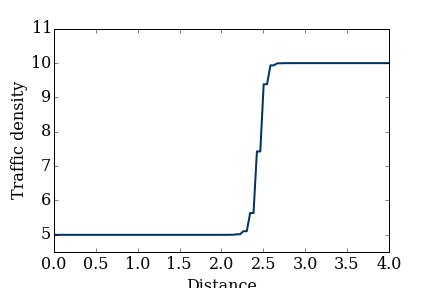
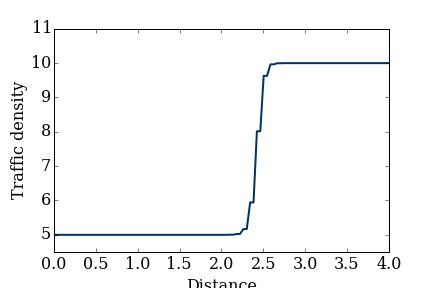
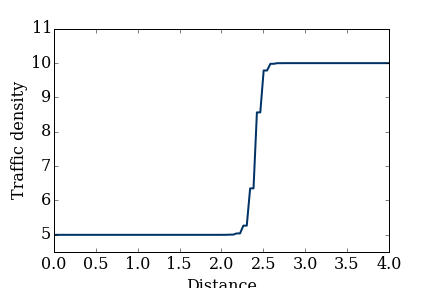
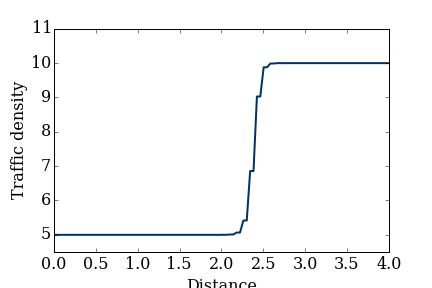

In [20]:
fig = plt.figure();
ax = plt.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')